In [10]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KernelDensity

In [19]:
class Estimate():
    
    def __init__(self, name, mean=None, std=None, vals=None, weights=None):

        if vals is None:
            assert (mean is not None and std is not None) 
                    
        self.name = name
        self.mean = mean
        self.std = std
        self.vals = vals
        self.weights = weights

        if vals is not None:
            self.loglikelihood = self.kdelikelihood_hist()

    def kdelikelihood_hist(self, kde_kernel="gaussian", bandwidth=2, nbins_hist=100): 
        
        if self.weights is not None:
            weights = self.weights
        else:
            weights = np.ones(len(self.vals))
            
        hist = np.histogram(self.vals, bins=nbins_hist, weights=weights)
        vals = hist[0]
        bins = [(h + hist[1][i+1])/2.0 for i, h in enumerate(hist[1][:-1])]

        # ignore potential zero weights, sklearn does not like them
        kde_bins = [(b,) for v, b in zip(vals, bins) if v>0]
        kde_weights = [v for v in vals if v>0]

        kde = KernelDensity(kernel=kde_kernel, bandwidth=bandwidth).fit(kde_bins, sample_weight=kde_weights)        
        return kde.score         
        
   
    def compute_percentiles(self):
        if not self.vals:
            return (self.mean-self.std, self.mean, self.mean+self.std)
        elif not self.weights:
            return np.percentile(a=self.vals, q=[16, 50, 84])
        else:
            ci = confinterval(xs=self.vals, weights=self.weights, conflevel=0.68)
            return (ci[0]-ci[1], ci[0], ci[0]+ci[2])
      
    
    def evaluate(self, H0s):
        if self.vals is not None:
            evals = np.exp(-(H0s - self.mean)**2 /(2*self.std **2))
        else:
            evals = np.exp(self.loglikelihood(H0s))
        return evals / np.sum(evals)

            
#def combine_estimates(estimates):       

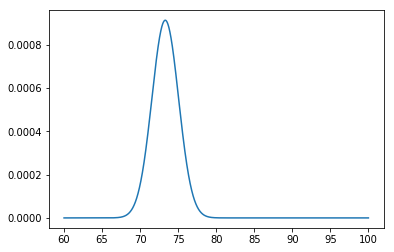

In [20]:
# tdc = [73.3, 1.75, 1.75]

tdc = Estimate(name="tdc", mean=73.3, std=1.75, vals=flat, weights=weights_tdc)

flat = np.linspace(60, 100, num=10000)
plt.plot(flat, tdc.evaluate(flat))

In [3]:
def confinterval(xs, weights=None, displayhist=False, conflevel=0.68, cumulative=False, bound='max'):
    """
    Hand-made weighted quantile/percentile computation tool, since there is no numpy equivalent

    :param xs: list, distribution
    :param weights: list, weights of the distribution
    :param displayhist: bool. Show a nice plot
    :param conflevel: float, quantile (between 0 and 1) of the conf interval
    :param cumulative: bool. If set to True, return the "bound" (min or max) value of xs corresponding to the conflevel. For example, if bound=max, conflevel=0.68, xs=nnu, return the value such that nnu<=val at 68% confidence.
    :param bound: 'max' or 'min', depending on the xs distribution. Valid only if cumulative is set to True
    :return: return 3 floats: the median value, minimal value and maximal value matching your confidence level
    
    __warning:: This function is not optimized, so it can be really slow if you apply it to very large data sets.
                However, for the samples we are dealing with here (around 50k), that's enough (fraction of seconds)
    
    __note:: This function has been compared to numpy.percentiles for uniform weights 
                and give similar results (at 0.02%). For non-uniform weights, it is able to reproduce the
                results from the Planck collaboration with the same level of precision
    
    """

    hist, bin_edges = np.histogram(xs, weights=weights, bins=1000)

    if not cumulative:
        frac = 0
        for ind, val in enumerate(hist):
            frac += val
            if frac/sum(hist) >= 0.5:
                meanval = (bin_edges[ind]+bin_edges[ind-1])/2.0
                break

        lowerhalf = 0
        upperhalf = 0
        for ind, val in enumerate(bin_edges[:-1]):
            if val < meanval:
                lowerhalf += hist[ind]
            else:
                upperhalf += hist[ind]


        limfrac = (1.0 - conflevel) / 2.0
        lowerfrac, upperfrac = 0, 0
        for ind, val in enumerate(hist):
            lowerfrac += val
            if lowerfrac/sum(hist) > limfrac:
                bottomlimit = (bin_edges[ind]+bin_edges[ind-1])/2.0
                break

        for ind, val in enumerate(hist):
            upperfrac += val
            if upperfrac/sum(hist) > 1.0 - limfrac:
                toplimit = (bin_edges[ind]+bin_edges[ind-1])/2.0
                break

        return meanval, (meanval-bottomlimit), -1.0*(meanval-toplimit)

    else:
        frac = 0
        for ind, val in enumerate(hist):
            frac += val
            if frac/sum(hist) >= conflevel:
                return (bin_edges[ind]+bin_edges[ind-1])/2.0
            
def reweight_posterior(H0_chain, mean, sigma):
    weights = np.exp(-(H0_chain - mean)**2 /(2*sigma **2))
    return weights            

In [23]:
# initialize the values: mean, error up, error down

planck = [67.4, 0.5, 0.5]
des = [67.4, 1.1, 1.2]
shoes = [74.03, 1.42, 1.42] 
cchp = [69.8, 1.9, 1.9]
tdc = [73.3, 1.75, 1.75]  # Gaussian approx. of the real likelihood
miras = [73.6, 3.9, 3.9]
masers = [74.8, 3.1, 3.1]
sbf_cepheids = [76.5, 4, 4]
sbf_trgb = [76.1, 6.6, 6.6]

percentiles = [16, 50, 84]

flat = np.linspace(60, 100, num=10000)

In [27]:
weights_tdc = reweight_posterior(flat, tdc[0], tdc[1])
weights_shoes = reweight_posterior(flat, shoes[0], shoes[1])
weights_cchp = reweight_posterior(flat, cchp[0], cchp[1])
weights_masers = reweight_posterior(flat, masers[0], masers[1])
weights_miras = reweight_posterior(flat, miras[0], miras[1])
weights_sbf_cepheids = reweight_posterior(flat, sbf_cepheids[0], sbf_cepheids[1])
weights_sbf_trgb = reweight_posterior(flat, sbf_trgb[0], sbf_trgb[1])

weights_ceph =  weights_tdc * weights_shoes * weights_masers * weights_sbf_trgb
weights_trgb = weights_tdc * weights_cchp * weights_masers * weights_sbf_cepheids
weights_combmiras = weights_tdc * weights_miras * weights_masers * weights_sbf_trgb

weights_all = weights_tdc * weights_shoes * weights_cchp * weights_miras * weights_masers * weights_sbf_cepheids

local_ceph = confinterval(flat, weights=weights_ceph, displayhist=True, conflevel=0.68, cumulative=False, bound='max')
local_trgb = confinterval(flat, weights=weights_trgb, displayhist=True, conflevel=0.68, cumulative=False, bound='max')
local_miras = confinterval(flat, weights=weights_combmiras, displayhist=True, conflevel=0.68, cumulative=False, bound='max')
local_all = confinterval(flat, weights=weights_all, displayhist=True, conflevel=0.68, cumulative=False, bound='max')

print ("Combined Local CEPH Measurement : %2.2f +%2.2f -%2.2f"%(local_ceph[0], local_ceph[2], local_ceph[1]))
print ("Combined Local TRGB Measurement : %2.2f +%2.2f -%2.2f"%(local_trgb[0], local_trgb[2], local_trgb[1]))
print ("Combined Local MIRAS Measurement : %2.2f +%2.2f -%2.2f"%(local_miras[0], local_miras[2], local_miras[1]))
print ("Combined Local Measurements : %2.2f +%2.2f -%2.2f"%(local_all[0], local_all[2], local_all[1]))

-5.33236703191e-17
Combined Local CEPH Measurement : 73.86 +1.04 -1.00
Combined Local TRGB Measurement : 72.46 +1.12 -1.12
Combined Local MIRAS Measurement : 73.74 +1.36 -1.40
Combined Local Measurements : 73.10 +0.84 -0.88


In [20]:
#compute tension : 
tension_tdc = (tdc[0] - planck[0])/np.sqrt(planck[1]**2 + tdc[2]**2)
tension_local_ceph = (local_ceph[0] - planck[0])/np.sqrt(planck[1]**2 + local_ceph[1]**2)
tension_local_trgb = (local_trgb[0] - planck[0])/np.sqrt(planck[1]**2 + local_trgb[1]**2)
tension_local_miras = (local_miras[0] - planck[0])/np.sqrt(planck[1]**2 + local_miras[1]**2)
tension_local_all = (local_all[0] - planck[0])/np.sqrt(planck[1]**2 + local_all[1]**2)

print("tension local ceph : %2.2f"%tension_local_ceph)
print("tension local trgb : %2.2f"%tension_local_trgb)
print("tension local miras : %2.2f"%tension_local_miras)
print("tension local all : %2.2f"%tension_local_all)

tension local ceph : 5.78
tension local trgb : 4.13
tension local miras : 4.26
tension local all : 5.63


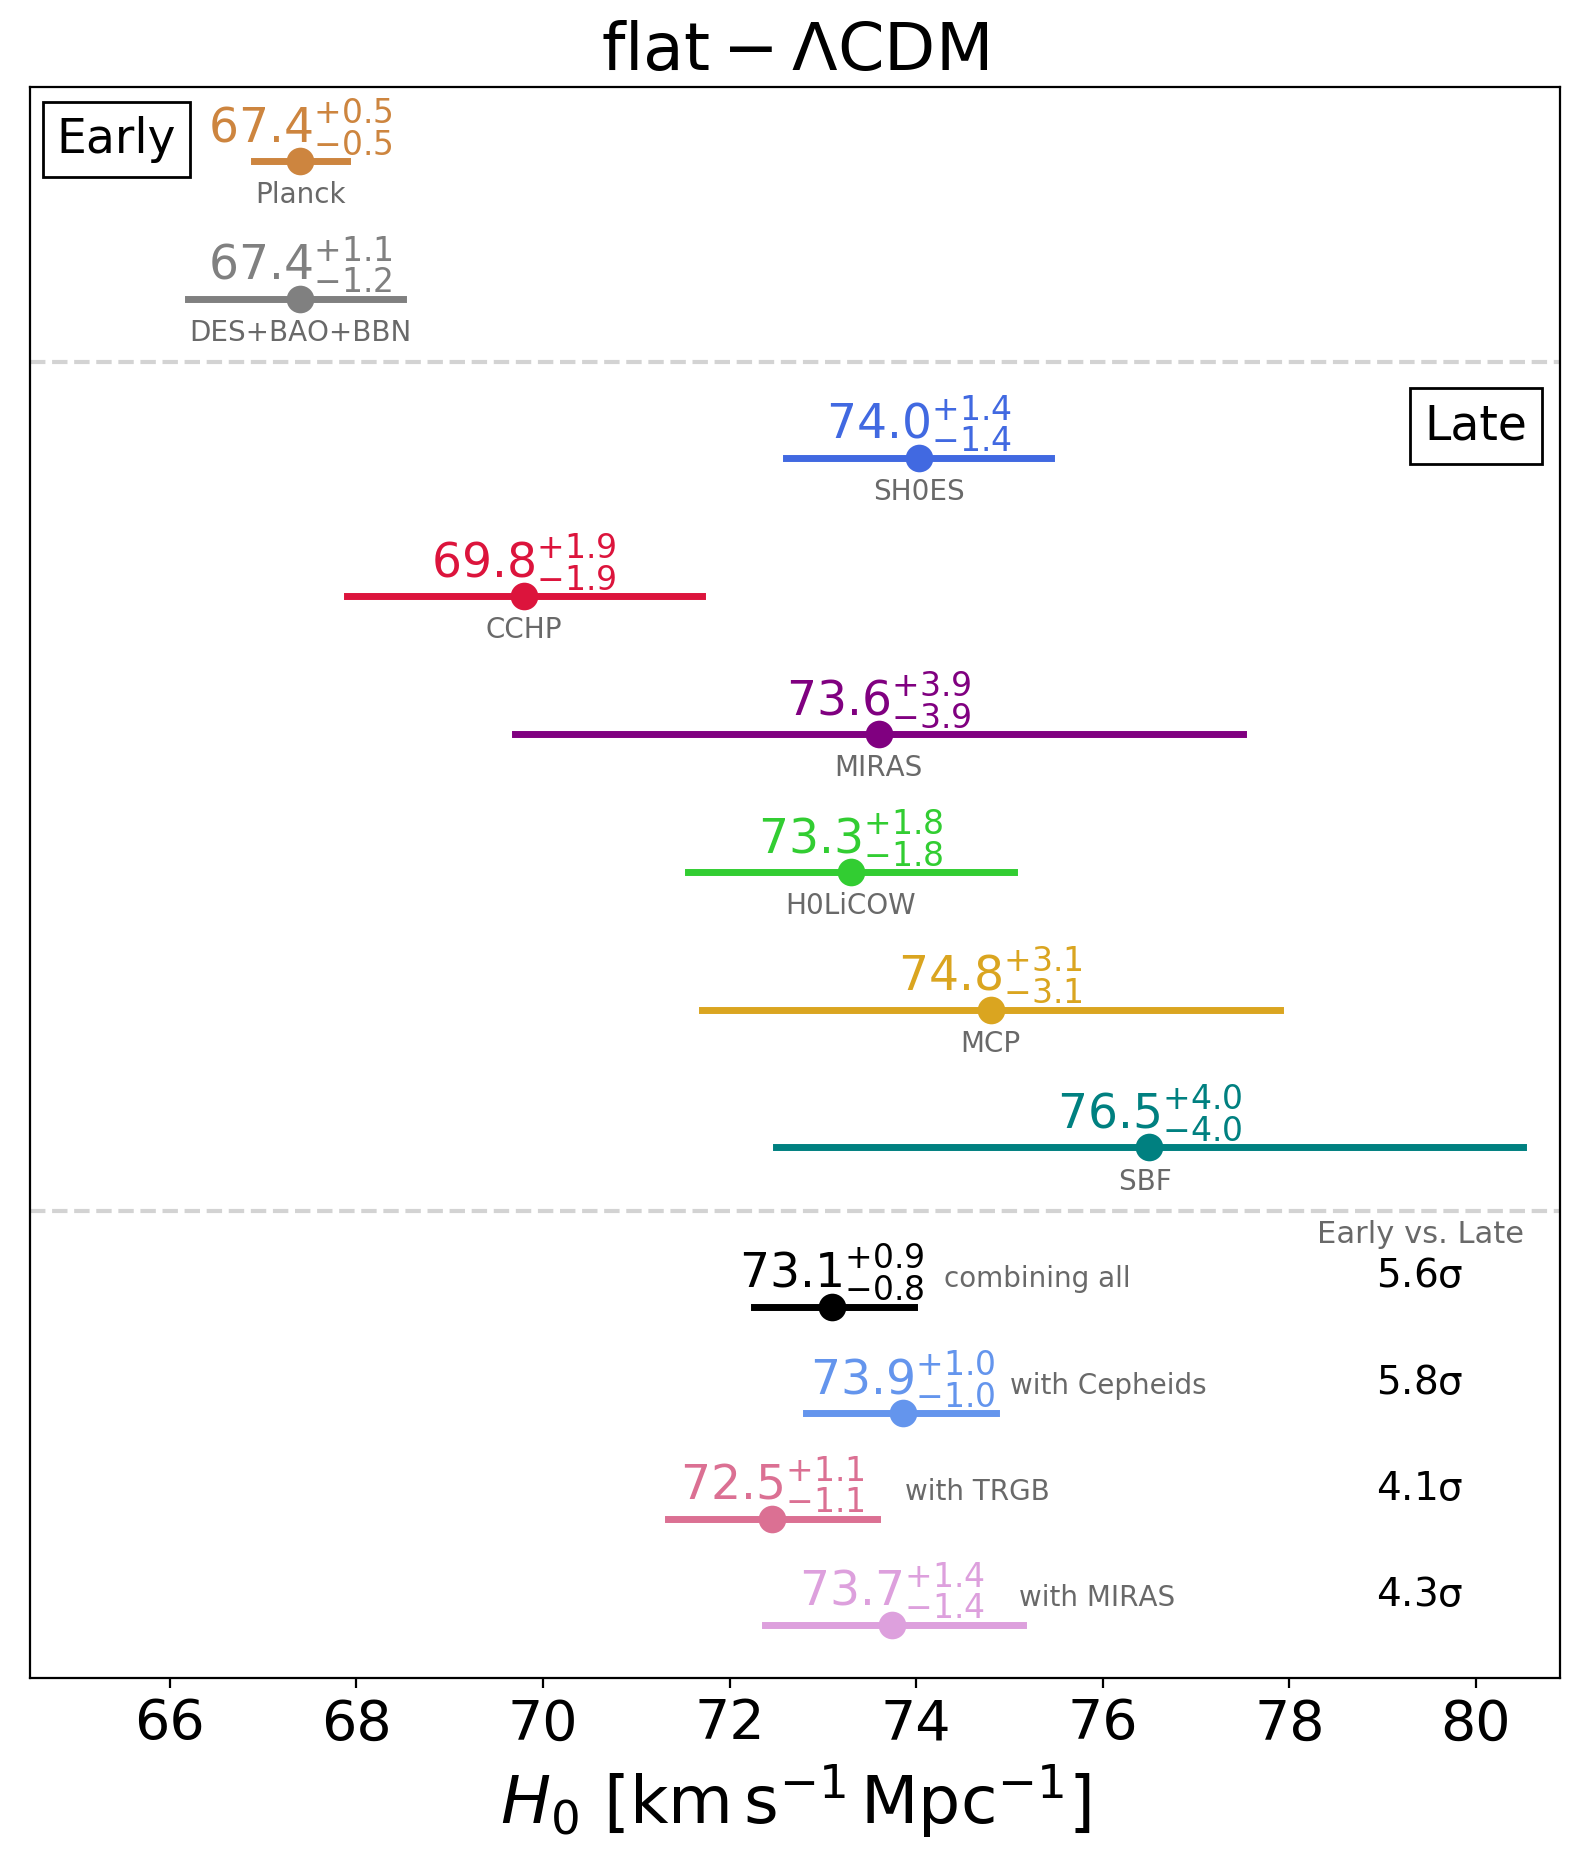

In [27]:
# Special design

plt.figure(figsize=(8.0, 9.4), dpi=200)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.20, top=0.92)

ax = plt.subplot(1, 1, 1)

plt.xlabel(r"$H_0\rm{\ [km\,s^{-1}\,Mpc^{-1}]}$", fontsize=24)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)

xs = [planck, des, shoes, cchp, miras, tdc, masers, sbf_cepheids, local_all, local_ceph, local_trgb, local_miras]
#ys = [13.8, 12.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4, 3, 2, 1]
ys = [14.8, 13.5, 12.0, 10.7, 9.4, 8.1, 6.8, 5.5, 4, 3, 2, 1]

colors = ['peru', 'grey', 'royalblue', 'crimson', 'purple', 'limegreen',
          'goldenrod', 'teal', 'black', 'cornflowerblue',  'palevioletred', 'plum']
labels = ['Planck', "DES+BAO+BBN", 'SH0ES',
          'CCHP', 'MIRAS', 'H0LiCOW',
          "MCP", "SBF ",
          'combining all', 'with Cepheids', 'with TRGB', 'with MIRAS']

plt.axis([64.5, 80.9, 0.5, 15.5]) # 75.6
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title(r'$\rm{flat-\Lambda CDM}$', fontsize=24)

for x, y, c, l in zip(xs, ys, colors, labels):
    plt.scatter(x[0], y, s=80, edgecolor=c, c=c, label=l)
    plt.plot([x[0]-x[2], x[0]+x[1]], [y, y], linewidth=2.5, color=c)

    if l not in ['combining all', 'with Cepheids', 'with TRGB', 'with MIRAS']:
        delaytext = r"$%.1f^{+%.1f}_{-%.1f}$" % (x[0], x[1], x[2])
        plt.annotate(delaytext, xy=(x[0], y + 0.18), color = c, horizontalalignment="center", fontsize=17)
        plt.annotate(l, xy=(x[0], y-0.4), color = "dimgrey", horizontalalignment="center", fontsize=10)        

    else:
        delaytext = r"$%.1f^{+%.1f}_{-%.1f}$" % (x[0], x[1], x[2])
        plt.annotate(delaytext, xy=(x[0], y + 0.18), color = c, horizontalalignment="center", fontsize=17)
        plt.annotate(l, xy=(x[0]+ 2.2, y + 0.18), color = "dimgrey", horizontalalignment="center", fontsize=10)           

# dashed lines to split early, late and combinations
plt.axhline(12.9, color="darkgrey", ls='--', alpha=0.5)
plt.axhline(4.9, color="darkgrey", ls='--', alpha=0.5)

# subpanels labels
bbox_props = dict(boxstyle="square", lw=1,  fc="white")
plt.annotate("Early", xy=(66.07, 15.0), color = "black", 
             horizontalalignment="right", verticalalignment="center", fontsize=17, bbox=bbox_props)
plt.annotate("Late", xy=(80.55, 12.3), color = "black", 
             horizontalalignment="right", verticalalignment="center", fontsize=17, bbox=bbox_props)


# printing the tension with Planck

plt.annotate("Early vs. Late", xy=(79.4, 4.6), color = "dimgrey", 
             horizontalalignment="center", fontsize=11)

xpos = 79.4
plt.annotate(r"$\rm{%.1f\sigma}$" % tension_local_all, xy=(xpos, 4.18), color = "black", 
             horizontalalignment="center", fontsize=14)
plt.annotate(r"$\rm{%.1f\sigma}$" % tension_local_ceph, xy=(xpos, 3.18), color = "black", 
             horizontalalignment="center", fontsize=14)
plt.annotate(r"$\rm{%.1f\sigma}$" % tension_local_trgb, xy=(xpos, 2.18), color = "black", 
             horizontalalignment="center", fontsize=14)
plt.annotate(r"$\rm{%.1f\sigma}$" % tension_local_miras, xy=(xpos, 1.18), color = "black", 
             horizontalalignment="center", fontsize=14)

plt.tight_layout()
plt.savefig('H0_tension.pdf', dpi=200)